In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
K = tc.set_backend('jax')

In [3]:
# numpy data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0


def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = y == a
    return x, y

x_train, y_train = filter_pair(x_train, y_train, 1, 5)
x_train_small = tf.image.resize(x_train[..., tf.newaxis], (16, 16)).numpy()[..., 0].reshape(-1, 256)
x_train_small = x_train_small / jnp.sqrt(jnp.sum(x_train_small**2, axis=-1, keepdims=True))

In [4]:
x_train_small.shape

(12163, 256)

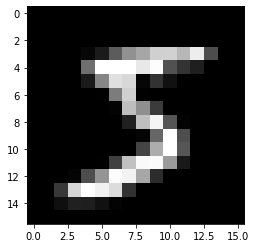

In [5]:
plt.imshow(x_train_small[0].reshape(16, 16), cmap='gray')

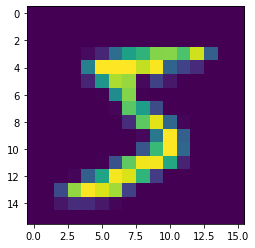

In [6]:
c = tc.Circuit(8, inputs=x_train_small[0])

plt.imshow(jnp.real(c.wavefunction().reshape(16, 16)))


In [7]:
data = tf.data.Dataset.from_tensor_slices((x_train_small, y_train)).shuffle(100).batch(128)

In [8]:
def loss(params, x, y, k):
    c = tc.Circuit(8, inputs=x)
    for j in range(k):
        for i in range(8 - 1):
            c.cnot(i, i + 1)
        for i in range(8):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = (jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2
    return -(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
loss = K.jit(loss, static_argnums=[3])

In [9]:
def accuracy(params, x, y, k):
    c = tc.Circuit(8, inputs=x)
    for j in range(k):
        for i in range(8 - 1):
            c.cnot(i, i + 1)
        for i in range(8):
            c.rx(i, theta=params[2 * j, i])
            c.ry(i, theta=params[2 * j + 1, i])
    y_pred = jnp.round((jnp.real(c.expectation([tc.gates.z(), [0,]])) + 1) / 2)
    return y_pred == y
accuracy = K.jit(accuracy, static_argnums=[3])

In [10]:
k = 6
params = K.randn((k * 2, 8), dtype=jnp.float32)

In [11]:
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

In [12]:
compute_loss = K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2])
compute_accuracy = K.vmap(accuracy, vectorized_argnums=[1, 2])

In [13]:
loss_list = []
acc_list = []
for i, (x, y) in tqdm(enumerate(data)):
    x = x.numpy()
    y = y.numpy()
    loss_val, grad_val = compute_loss(params, x, y, k)
    updates, opt_state = opt.update(grad_val, opt_state, params)
    params = optax.apply_updates(params, updates)
    loss_mean = jnp.mean(loss_val)
    if i % 5 == 0:
        acc = jnp.mean(compute_accuracy(params, x, y, k))
        acc_list.append(acc)
        loss_list.append(loss_mean)
        print(f'{i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

0it [00:00, ?it/s]

0/96: loss=0.6846, acc=0.6094
5/96: loss=0.6538, acc=0.8203
10/96: loss=0.6402, acc=0.8594
15/96: loss=0.6107, acc=0.8828
20/96: loss=0.5873, acc=0.9219
25/96: loss=0.5792, acc=0.8984
30/96: loss=0.5640, acc=0.9297
35/96: loss=0.5700, acc=0.8516
40/96: loss=0.5384, acc=0.9609
45/96: loss=0.5325, acc=0.8828
50/96: loss=0.5135, acc=0.9375
55/96: loss=0.5139, acc=0.9141
60/96: loss=0.5095, acc=0.9141
65/96: loss=0.5031, acc=0.8906
70/96: loss=0.4817, acc=0.9688
75/96: loss=0.5083, acc=0.8828
80/96: loss=0.4769, acc=0.9766
85/96: loss=0.4934, acc=0.9219
90/96: loss=0.4825, acc=0.9375
95/96: loss=0.3958, acc=1.0000


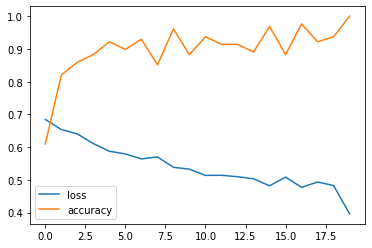

In [14]:
plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.show()